In [1]:
# All Imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import requests
from PIL import Image

In [2]:

def load_image(name, no_alpha=True):
    url = f'https://cloud.dfki.de/owncloud/index.php/s/THLirfoB6SYTetn/download?path=&files={name}'
    image = np.asarray(Image.open(requests.get(url, stream=True).raw))
    if no_alpha and len(image) > 2 and image.shape[2] == 4:
        image = image[:,:,:3]
    return image[:,:,::-1].copy()

def resize(image, scale):
    return cv2.resize(image, (int(image.shape[1]*scale), int(image.shape[0]*scale)))

def show(*images, titles=None, figsize=None, **kwargs):
    ROWS, COLS = 1, len(images)
    if figsize is not None:
        plt.figure(figsize=(18,6))
    for i, img in enumerate(images):
        plt.subplot(ROWS, COLS, i+1)
        if titles is not None:
            plt.title(titles[i])
        if len(img.shape) == 3:
            plt.imshow(img[:,:,::-1], **kwargs)
        else:
            plt.imshow(img, **kwargs)
    plt.show()
    
def gray(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    
def gaussian_blur(image, size=3, sigma=0):
    return cv2.GaussianBlur(image, (size, size), sigma)

def visualize_keypoints_and_orientations(img, keypoints):
    fig, ax = plt.subplots(1)
    ax.imshow(img, cmap='gray')
    for point in keypoints:
        u, v, _, orient = point
        circle = patches.Circle((v, u), radius=10, edgecolor='r', facecolor='none')
        ax.add_patch(circle)
        dx = 10 * np.cos(np.deg2rad(orient * 45))
        dy = 10 * np.sin(np.deg2rad(orient * 45))
        ax.arrow(v, u, dx, dy, color='r', head_width=2, head_length=2)
    plt.show()


<p style="page-break-after:always;"></p>

# Task: SIFT concepts
---
<div style="background-color: #ffa252; color: #ffffff; width: 100%; padding: 0.3em; font-size:1.1em; font-weight: bold;">SIFT</div>
<div style="background-color: #ffecdc; width: 100%; padding-top: 0.5em; padding-bottom: 0.3em">

Original SIFT algorithm is performed in 4 steps:

1. **Scale-space Extrema Detection**: The first step of SIFT features extraction algorithm is to identify key locations in the image to be used for further processing. These locations are called keypoints.
2. **Keypoint Localization**: Once potential keypoints locations are found, they have to be refined to get more accurate results.
3. **Orientation Assignment**: Assign a consistent orientation to each keypoint based on local image properties. This step ensures that the SIFT descriptor is rotation invariant.
4. **Keypoint Descriptor**: The last step of the algorithm is to compute the SIFT descriptors. The descriptor is a vector that holds the keypoint's main features.

</div>

Implementation of the whole algorithm is hard and time-consuming task to the overall complexity and non-obvious implementation pitfalls.

Within this notebook, we will instead investigate three first concepts of SIFT.

**Given Step:**
* Load the images `img1.png` and `img2.png` and convert them to grayscale

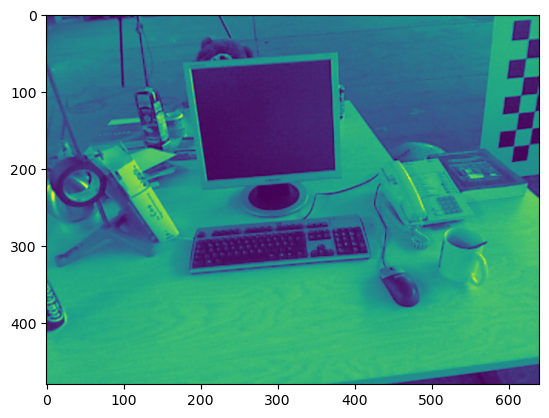

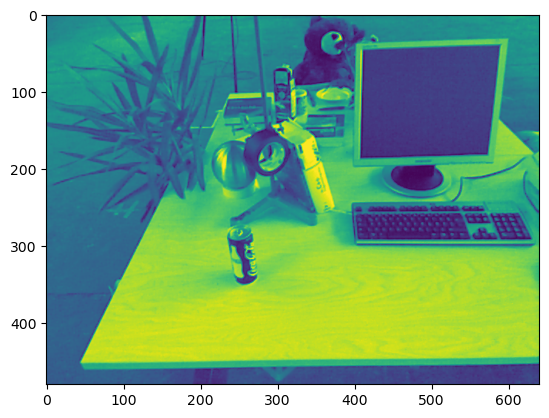

In [3]:
img1 = gray(load_image("img1.png"))
img2 = gray(load_image("img2.png"))

show(img1)
show(img2)

### 1. Scale-space extrema generation

Scale space is formed based on the different octaves, each image in which is convolved with the Gaussian kernel with specific sigma value.
Original implementation of SIFT works on multiple octaves.
To make it simplier, we will generate only one octave on original resolution.

Function to generate DoG images from the input and find extrema on them.

You should generate Gaussian-blured images ($I_1, I_2, I_3, I_4$ etc.) by convolving the **original** image with Gaussian kernel, which depend on the sigma value.

Sigma values for every Gaussian-blured image should be multiplications of original sigma based on the image index + 1 ($\sigma_{I_1}=0.5, \sigma_{I_2}=1.0, \sigma_{I_3}=1.5$ etc.). You are free to adjust it if the number of points in return is not satisfactory (i.e. below 50).

**Note:** original SIFT implementation uses 1.6 as starting value for $\sigma$. Here, due to the algorithm simplification, we have to adjust it to simply provide more points.

DoG images should be generated as $D_1 = I_2 - I_1, D_2 = I_3 - I_2, D_3 = I_4 - I_3$ etc. 

![image.png](image.png)

Extrema search should be performed on every possible 3x3x3 neighborhood of three DoG images $((D_1, D_2, D_3), (D_2, D_3, D_4))$ etc. 

![image-1.png](image-1.png)

During the points traversing, the suitable scale is also selected.

In [4]:
num_images = 5
sigma = 0.5
# Generate sigmas for different scales (0.5, 1.0 etc.) (num_images)
sigmas = [sigma * (i + 1) for i in range(num_images)]

def extrema_condition(neighborhood: np.array) -> bool:
    # TODO Check if the center value of the 3x3x3 neighborhood is a maximum or minimum within the neighbourhood
    # Return True if the extrema condition holds, False otherwise
    # Check whether the central value of the 3x3x3 matrix is either max or min
    if np.max(neighborhood)==neighborhood[1,1,1] or np.min(neighborhood)==neighborhood[1,1,1]:
        return True
    else:
        return False

# Function returns the coordinate of extrema (y, x) together with the index of Gaussian sigma (scale in terminology of SIFT), on which the extrema was found 
def find_local_extrema(dog_low: np.array, dog_mid: np.array, dog_upp: np.array, idx_scale: float) -> np.array:
    extrema = []
    for (y, x), value in np.ndenumerate(dog_mid[1:-1, 1:-1]):
        y = y + 1
        x = x + 1
        # Get the 3x3x3 neighborhood around the pixel
        neighborhood = np.stack(
            [dog_low[y-1:y+2, x-1:x+2],
             dog_mid[y-1:y+2, x-1:x+2],
             dog_upp[y-1:y+2, x-1:x+2]])
        if extrema_condition(neighborhood):
            extrema.append([y, x, idx_scale])
    return extrema

def sigma_to_window_size(sigma: float) -> float:
    return max(3, int(2 * np.ceil(3 * sigma) + 1))

def estimate_gaussian_images_dog_and_extrema(image: np.array):
    # Convert the source image to floating point
    image = image.copy().astype(float)
    # Convolve original image with different Gaussian kernels (size: num_images)
    # TODO Set sigma based on the previously generated sigmas, and size based on the output of sigma_to_window_size
    gaussian_images = []                                                                                    # Initialising the gaussian_images list
    for i in range(len(sigmas)):
        gaussian_images.append(gaussian_blur(image,sigma_to_window_size(sigmas[i]),sigmas[i]))
    # TODO Generate DoG images for every pair (size: num_images - 1)
    dog = []                                                                                                # Initialising the difference in gaussian list
    for i in range(len(gaussian_images)-1):
        dog.append(gaussian_images[i]-gaussian_images[i+1])
    # TODO Find extrema in every triplet of DoG images (size: num_images - 3), use the index of the middle image as idx_scale argument
    extrema = []                                                                                            # Initialising the extrema list
    for i in range (1,len(dog)-1):
        extrema.append(find_local_extrema(dog[i-1],dog[i],dog[i+1],i-1))
    # Flattening the list
    extrema = [item for sublist in extrema for item in sublist]

    print(f"Number of initial points: {len(extrema)}")

    return gaussian_images, dog, extrema

### 2. Keypoints localization

The second part of the SIFT algorithm is keypoint localization. In this step, we refine the location of the keypoints and eliminate low-contrast keypoints and edge responses.

In the full SIFT algorithm, this involves a complex process of interpolating the location of the extrema in the DoG pyramid with subpixel accuracy, computing the contrast at this interpolated location, and eliminating keypoints that have a contrast less than a certain threshold together with computing the principal curvature of the DoG at the keypoint location and eliminating keypoints that have a ratio of principal curvatures greater than a certain threshold (to eliminate edge responses).

We do it in simplified way -- by thresholding the absolute values of DoG image and keeping the points, value of which is higher than the threshold.

Fill the missing parts in the functions for keypoint localization.
Based on the text description, make the condition for filtering the keypoints.

In [5]:
def keypoint_localization(DoG: list, extrema: list, contrast_threshold=1) -> list:
    # Find the contrast of each keypoint as the abs of pixel in DoG image on specific scale
    keypoints = []                                                                          # Initialising the keypoints list

    def filtering_condition(value, contrast_threshold):
        # TODO generate proper condition of the value being bigger than threshold 
        if value>contrast_threshold:
            return True
        else:
            return False

    for idx, point in enumerate(extrema):
        y, x, idx_scale = point
        # TODO Set the value according to the text description (absolute value of DoG on specific scale)
        value = np.abs(DoG[idx_scale][y,x])
        if filtering_condition(value, contrast_threshold):
            keypoints.append(point)

    print(f"Number of filtered points: {len(keypoints)}")

    return keypoints

### 3. Orientation assignment

In this step each keypoint is assigned one or more orientations based on local image gradient directions. This is the key step in achieving invariance to rotation as the keypoint descriptor can be represented relative to this orientation and therefore allows for the descriptor to be rotation invariant.

Perform magniture and orientation estimation on every Gaussian-blur image for every keypoint within the defined window, and fill the histogram based on the orientation values.

![image-3.png](image-3.png)

Original SIFT is using histogram of 36 bins (10 degrees step). Here, you need to perform the orientation estimation with 8 bins (45 degrees step).

In [6]:
def orientation_assignment(gaussian_images: list, keypoints: list, num_bins=8) -> list:
    assigned_points = []
    for idx, point in enumerate(keypoints):
        u, v, idx_scale = point
        # If num_bins=8, then indices correspond to 0, 45, 90, 135, 180, 225, 270, 315 degrees respectively
        bins = [0]*num_bins
        # Select window size based on the sigma for specific scale
        window_size = sigma_to_window_size(sigmas[idx_scale])
        half_window_size = window_size // 2
        # Select image based on scale
        im = gaussian_images[idx_scale]
        # Check if the values are within image borders
        if (u > half_window_size + 1 and u < im.shape[0] - half_window_size - 1 and v > half_window_size + 1 and v < im.shape[1] - half_window_size - 1):
            for _y in range(-half_window_size, half_window_size+1, 1):
                for _x in range(-half_window_size, half_window_size+1, 1):
                    y = u + _y
                    x = v + _x
                    # Refer to the pixel in image as im[y, x]
                    # Use the formulas from above
                    # TODO Define dx, dy based on the formulas
                    dx = (gaussian_images[idx_scale][y+1,x]-gaussian_images[idx_scale][y-1,x])
                    dy = (gaussian_images[idx_scale][y,x+1]-gaussian_images[idx_scale][y,x-1])
                    # TODO Define magnitude and orientation based on the formulas
                    magnitude = np.sqrt(dx*dx+dy*dy)
                    orientation = np.arctan2(dy,dx)
                    # Magnitude is used for the orientation values normalization, but in this implementation we'll skip this step
                    # TODO Assign the histogram value based on the orientation, i.e. define bin_idx based on the orientation
                    bin_idx = int(orientation/(2*np.pi*num_bins))
                    bins[bin_idx] += 1
            # TODO find the dominant orientation in histogram using np.argmax()
            idx_orient = np.argmax(bin_idx)
            # Add a result to the dictionary in a form of keypoint coordinate and its orientation 
            assigned_points.append([u, v, idx_scale, idx_orient])

    print(f"Number of keypoints with orientation: {len(assigned_points)}")
    return assigned_points

In [7]:
def sift_steps(image: np.array) -> dict:
    # Function call to estimate gaussian images, difference in gaussian and the extrema of the image
    gaussian_images, dog, extrema = estimate_gaussian_images_dog_and_extrema(image) 
    # Function call to find the keypoint localisation
    keypoints = keypoint_localization(dog, extrema) 
    # Function call for orientation and magnitude assignment
    oriented_keypoints = orientation_assignment(gaussian_images, keypoints)
    return oriented_keypoints

In [8]:
keypoints1 = sift_steps(img1)
keypoints2 = sift_steps(img2)

Number of initial points: 138
Number of filtered points: 118
Number of keypoints with orientation: 116
Number of initial points: 145
Number of filtered points: 133
Number of keypoints with orientation: 133


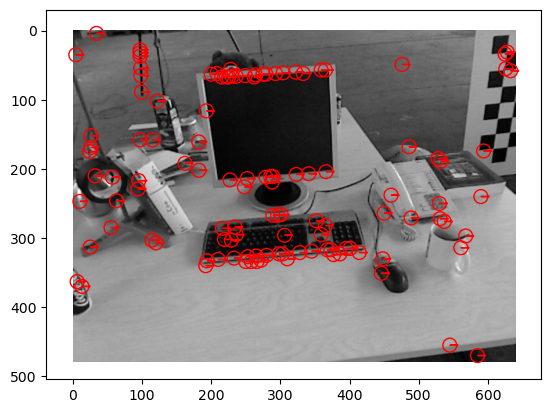

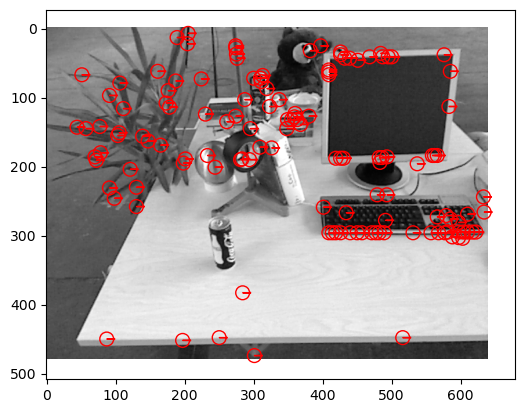

In [9]:
visualize_keypoints_and_orientations(img1, keypoints1)
visualize_keypoints_and_orientations(img2, keypoints2)